In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.metrics import roc_curve, roc_auc_score

print("DONE")

DONE


We will start by reading in the by now standard Titanic dataset. It contains infromation about passengers of the Titanic. The informations contain i.a. sex, age, name and familly and passenger class as well as information if the passenger survived or died in the disaster. You can find more information about this data set [here](http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf). 

The data set is in "coma separted values" (csv) format and the read it we will use the [pandas](https://pandas.pydata.org) library. Pandas library provides tools for manipulating  data frames and series and is widly used in data science projects. 

In [3]:
data = pd.read_csv("titanic3.csv")

We can check what attributes are stored in the DataFrame by listing the column names:

In [4]:
data.columns

Index(['Unnamed: 0', 'pclass', 'survived', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body',
       'home.dest'],
      dtype='object')

or get a quick preview using ```head``` function: 

In [5]:
data.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


For the description of the features please see the link given above. 

Another usefull function is ```info```:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1309 non-null   int64  
 1   pclass      1309 non-null   int64  
 2   survived    1309 non-null   int64  
 3   name        1309 non-null   object 
 4   sex         1309 non-null   object 
 5   age         1046 non-null   float64
 6   sibsp       1309 non-null   int64  
 7   parch       1309 non-null   int64  
 8   ticket      1309 non-null   object 
 9   fare        1308 non-null   float64
 10  cabin       295 non-null    object 
 11  embarked    1307 non-null   object 
 12  boat        486 non-null    object 
 13  body        121 non-null    float64
 14  home.dest   745 non-null    object 
dtypes: float64(3), int64(5), object(7)
memory usage: 153.5+ KB


As we can see not all attributes are know (non-null) for every passanger. This is a frequent situation in real datasets. 

## Problem 1

a) Implement a Bayes classifier for predicting passenger survival  using sex and pclass  features. 

We will start by extracting from the frame the only the information we need:

In [7]:
data_pclass_sex = data[['pclass', 'sex', 'survived']]


dane=data_pclass_sex.values

print(len(dane))
print(dane[1][2])
print("DONE")

1309
1
DONE


In [8]:
print("\ninfo: \n")
print(data_pclass_sex.info())


info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pclass    1309 non-null   int64 
 1   sex       1309 non-null   object
 2   survived  1309 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 30.8+ KB
None


Then we need to group passengers according to sex, class and survival status. This can be achived using  the ```groupby``` function:

In [9]:
grouped = data_pclass_sex.groupby(['survived','sex','pclass'])

We can count the number of passegers in each group using function ```size```:

In [10]:
counts = grouped.size()

Object ```counts``` contains all the information that we need to construct the classifier:

In [11]:
print("\ncounts:\n")
print(counts)


counts:

survived  sex     pclass
0         female  1           5
                  2          12
                  3         110
          male    1         118
                  2         146
                  3         418
1         female  1         139
                  2          94
                  3         106
          male    1          61
                  2          25
                  3          75
dtype: int64


You can index ```counts``` to obtain information on specified subgroups. E.g. ```counts[0]``` is a subgroup  that contains people that perished in the disaster. 

In [39]:
print("\ntrain counts:\n")
print(counts[0])


train counts:

sex     pclass
female  1           5
        2          12
        3         110
male    1         118
        2         146
        3         418
dtype: int64


In [41]:
print("\nfemales who parished:\n")
print(counts[(0,'female')])


females who parished:

pclass
1      5
2     12
3    110
dtype: int64


Function ```sum``` can be used to count all passengers in a given (sub)group:

In [12]:
n_passengers = counts.sum()
n_survivors = counts[1].sum()
n_dead = counts[0].sum()

print(n_passengers, n_survivors, n_dead)
print(n_survivors+n_dead==n_passengers)

1309 500 809
True


To implement classifier we need to calculate the conditional probability of survival given sex and class:

$$P(surv|sex, pclass)$$

We can use the Bayes theorem but it will be actually quicker to calculate it directly from the definition:

$$P(surv|sex, pclass)=\frac{P(surv,sex, pclass)}{P(sex, pclass)}
\approx \frac{\#(surv,sex, pclass)}{\#(sex,pclass)}$$

where by $\#$ I have denoted the number of passengers with given attributes. For example the probability of survival for a women traveling in second class was: 

$$\frac{\text{number of women in second class that survived}}{\text{number of women in second class}}$$

That can be calculated using the `counts` object:

In [71]:
print((counts.loc[:,'female',:].sum()/counts.sum())*(counts.loc[:,:,1].sum()/counts.sum()))
print(counts.loc[:,'female',1].sum()/counts.sum())
print(counts.loc[:,'female',1])

0.08784340182353934
0.11000763941940413
survived
0      5
1    139
dtype: int64


This operation has to be repeated for every sex and class combination. 

b) Calculate TPR and FPR on the whole set. Draw the ROC curve and calculate AUC score

c) Are those featuyres conditionally independent? 

d) Implement a Naive bayes classifier using the same features and compare it with a). 


All combinations of passenger's features that I take into account.

[(0, 'female', 1), (0, 'female', 2), (0, 'female', 3), (0, 'male', 1), (0, 'male', 2), (0, 'male', 3), (1, 'female', 1), (1, 'female', 2), (1, 'female', 3), (1, 'male', 1), (1, 'male', 2), (1, 'male', 3)]

Number of possible combinations of these features.

12

Shape of the Bayes Classifier matrix:

(3, 2)

Bayes Classifier matrix:

[[0.96527778 0.34078212]
 [0.88679245 0.14619883]
 [0.49074074 0.15212982]]

Bayes Classifier Matrix, classification with treshold prob=0.5 output:

[[1 0]
 [1 0]
 [0 0]]

When prob>0.5 => return 1 else return 0


TP(for prob=0.5 treshold):  233
FP(for prob=0.5 treshold):  17
TN(for prob=0.5 treshold):  792
FN(for prob=0.5 treshold):  267


TPR(for prob=0.5 treshold):  0.466
FPR(for prob=0.5 treshold):  0.021013597033374538
TNR(for prob=0.5 treshold):  0.9789864029666254
FNR(for prob=0.5 treshold):  0.534
TNR+FPR(for prob=0.5 treshold):  1
TPR+FNR(for prob=0.5 treshold): 1

Let's make the 

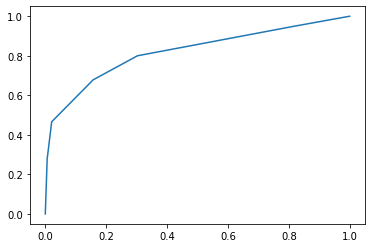

--------------AUC-------------------------------AREA---UNDER---CURVE-----------------------------------

0.8200012360939432


In [13]:
#b).

print("\nAll combinations of passenger's features that I take into account.\n")
combinations=counts.index.tolist()
print(combinations)

print("\nNumber of possible combinations of these features.\n")
n=len(combinations)
print(n)

Bayes=np.zeros((3,2))
Bayes_rev=np.zeros((3,2)) 

print("\nShape of the Bayes Classifier matrix:\n")
print(Bayes.shape)

for i in range(int(n/2)):
    if (i%2==0):
        ssx='female'
    else:
        ssx='male'
    Bayes[i%3][i%2]=counts.loc[1,ssx,int((i%3)+1)].sum()/(counts.loc[1,ssx,int((i%3)+1)].sum()\
                                                    +counts.loc[0,ssx,int((i%3)+1)].sum())
    Bayes_rev[i%3][i%2]=counts.loc[1,ssx,int((i%3)+1)].sum()/counts[1].sum()
    
print("\nBayes Classifier matrix:\n")   
print(np.matrix(Bayes))

Bayes_bin=np.zeros((3,2))
Bayes_bin=np.where(Bayes > 0.5, 1, 0)

print("\nBayes Classifier Matrix, classification with treshold prob=0.5 output:\n")
print(np.matrix(Bayes_bin))

TPR=0
FPR=0
TP=0
FP=0
TN=0
FN=0
P=0
N=0
score=[]
y=[]

for k in range(dane.shape[0]):
    
    pclasss=dane[k][0]
    sexx=dane[k][1]
    if(sexx=='male'):
        sexx=1
    else:
        sexx=0
    
    label=dane[k][2]
    
    y.append([label])
    score.append([Bayes[pclasss-1][sexx]])
    
    

    if(Bayes_bin[pclasss-1][sexx]==1):   
        if((dane[k][2]==Bayes_bin[pclasss-1][sexx])):
            TP=TP+1
            P=P+1
        else:
            FP=FP+1
            N=N+1
            
    if(Bayes_bin[pclasss-1][sexx]==0):   
        if((dane[k][2]==Bayes_bin[pclasss-1][sexx])):
            TN=TN+1
            N=N+1
        else:
            FN=FN+1
            P=P+1

print("\nWhen prob>0.5 => return 1 else return 0\n")            
print("\nTP(for prob=0.5 treshold): ", int(TP))
print("FP(for prob=0.5 treshold): ", int(FP))
print("TN(for prob=0.5 treshold): ", int(TN))
print("FN(for prob=0.5 treshold): ", int(FN))
print("\n")
print("TPR(for prob=0.5 treshold): ", float(TP/P))
print("FPR(for prob=0.5 treshold): ", float(FP/N))
print("TNR(for prob=0.5 treshold): ", float(TN/N))
print("FNR(for prob=0.5 treshold): ", float(FN/P))

print("TNR+FPR(for prob=0.5 treshold): ", int((TN+FP)/N))
print("TPR+FNR(for prob=0.5 treshold):", int((TP+FN)/P))

score_whole=np.array(score)
y_whole=np.array(y)

print("\nLet's make the above more general. Let's calculate TPR and FPR for several different tresholds")
print("and plot them against each other.\n")
print("--------------ROC---------------RECEIVER---OPERATOR---CHARACTERSTIC-----------------------------------\n")
      
fpr, tpr, thresholds = roc_curve(y_whole,score_whole)

print("When prob>treshold => return 1 else return 0\n")
print("\nprob tresholds:\n",thresholds)

plt.plot(fpr,tpr)
plt.show()
print("--------------AUC-------------------------------AREA---UNDER---CURVE-----------------------------------\n")
print(roc_auc_score(y_whole, score_whole))

In [14]:
#c) Are those features conditionally independent?

s=[(counts[combinations[6:9]].sum())/(counts[1].sum()),\
   (counts[combinations[9:12]].sum())/(counts[1].sum())]

p=[(counts.loc[1,:,int(i+1)].sum())/(counts[1].sum()) for i in range(3)]

print("\nsex matrix:\n[P(male^survived)/P(survived), P(female^survuved)/P(survived)]=")
print(s)
print("\npclass matrix:\n[P(pclass1^survived)/P(survived), P(pclass2^survived)/P(survived)\
,P(pclass3^survived)/P(survived)]=")
print(p)

Bayes_ind=np.zeros((3,2))
Bayes_com=np.zeros((3,2)) 

for j in range(2):
    for i in range(3):
        Bayes_ind[i][j]=p[i]*s[j]
    if(Bayes_rev[i][j]==Bayes_ind[i][j]):
        Bayes_com[i][j]=1
    else:
        Bayes_com[i][j]=0

        
print("\nP(sex^class|survival) matrix (female,male)vs(1,2,3):\n")
print(np.matrix(Bayes_rev))
print("\n P(sex|survival)P(class|survival) matrix (female,male)vs(1,2,3):\n")
print(np.matrix(Bayes_ind))
print("\n When the following matrix is filled with 1 exclusively \
\n P(sex^class|survival) (matrix) = \
P(sex|survival)P(class|survival (matrix):\n")
print(np.matrix(Bayes_com))
print("These features are not conditionally independent.")



sex matrix:
[P(male^survived)/P(survived), P(female^survuved)/P(survived)]=
[0.678, 0.322]

pclass matrix:
[P(pclass1^survived)/P(survived), P(pclass2^survived)/P(survived),P(pclass3^survived)/P(survived)]=
[0.4, 0.238, 0.362]

P(sex^class|survival) matrix (female,male)vs(1,2,3):

[[0.278 0.122]
 [0.188 0.05 ]
 [0.212 0.15 ]]

 P(sex|survival)P(class|survival) matrix (female,male)vs(1,2,3):

[[0.2712   0.1288  ]
 [0.161364 0.076636]
 [0.245436 0.116564]]

 When the following matrix is filled with 1 exclusively 
 P(sex^class|survival) (matrix) = P(sex|survival)P(class|survival (matrix):

[[0. 0.]
 [0. 0.]
 [0. 0.]]
These features are not conditionally independent.



Naive Bayes Classifier Matrix (female,male)vs(1,2,3):

[[1.17926361 0.30959605]
 [0.81818331 0.21480042]
 [0.48620091 0.12764396]]

Naive Bayes Classifier Matrix, classification with treshold prob=0.5 output, (female,male)vs(1,2,3):

[[1 0]
 [1 0]
 [0 0]]

When prob>0.5 => return 1 else return 0


TP(for prob=0.5 treshold):  233
FP(for prob=0.5 treshold):  17
TN(for prob=0.5 treshold):  792
FN(for prob=0.5 treshold):  267


TPR(for prob=0.5 treshold):  0.466
FPR(for prob=0.5 treshold):  0.021013597033374538
TNR(for prob=0.5 treshold):  0.9789864029666254
FNR(for prob=0.5 treshold):  0.534
TNR+FPR(for prob=0.5 treshold):  1
TPR+FNR(for prob=0.5 treshold): 1

Let's make the above more general. Let's calculate TPR and FPR for several different tresholds
and plot them against each other.

--------------ROC---------------RECEIVER---OPERATOR---CHARACTERSTIC-----------------------------------

When prob>treshold => return 1 else return 0


prob tresholds:
 [2.17926361 1.17926361 0.81818331 0

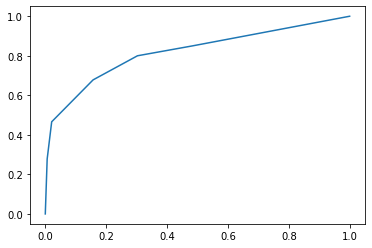

--------------AUC-------------------------------AREA---UNDER---CURVE-----------------------------------

0.8187651421508035


In [18]:
#d).
NaiveBayes=np.zeros((3,2))
for i in range(int(n/2)):
    if (i%2==0):
        ssxn='female'
    else:
        ssxn='male'
    NaiveBayesdenoms=(counts.loc[:,ssxn,:].sum())/(counts.sum())
    NaiveBayesdenompc=(counts.loc[:,:,int(i%3+1)].sum()/(counts.sum()))
    NaiveBayes[i%3][i%2]=((Bayes_ind[i%3][i%2]*counts[1].sum())/counts.sum())/(NaiveBayesdenoms*NaiveBayesdenompc)
                                                   
    
NaiveBayes_bin=np.zeros((3,2))
NaiveBayes_bin=np.where(NaiveBayes > 0.5, 1, 0)

print("\nNaive Bayes Classifier Matrix (female,male)vs(1,2,3):\n")
print(np.matrix(NaiveBayes))



print("\nNaive Bayes Classifier Matrix, classification with treshold prob=0.5 output, (female,male)vs(1,2,3):\n")
print(np.matrix(NaiveBayes_bin))

TPRn=0
FPRn=0
TPn=0
FPn=0
TNn=0
FNn=0
Pn=0
Nn=0
scoren=[]
yn=[]

for k in range(dane.shape[0]):
    
    pclasssn=dane[k][0]
    sexxn=dane[k][1]
    if(sexxn=='male'):
        sexxn=1
    else:
        sexxn=0
    
    labeln=dane[k][2]
    
    yn.append([labeln])
    scoren.append([NaiveBayes[pclasssn-1][sexxn]])
       
    if(NaiveBayes_bin[pclasssn-1][sexxn]==1):   
        if((dane[k][2]==NaiveBayes_bin[pclasssn-1][sexxn])):
            TPn=TPn+1
            Pn=Pn+1
        else:
            FPn=FPn+1
            Nn=Nn+1
            
    if(NaiveBayes_bin[pclasssn-1][sexxn]==0):   
        if((dane[k][2]==NaiveBayes_bin[pclasssn-1][sexxn])):
            TNn=TNn+1
            Nn=Nn+1
        else:
            FNn=FNn+1
            Pn=Pn+1

print("\nWhen prob>0.5 => return 1 else return 0\n")            
print("\nTP(for prob=0.5 treshold): ", int(TPn))
print("FP(for prob=0.5 treshold): ", int(FPn))
print("TN(for prob=0.5 treshold): ", int(TNn))
print("FN(for prob=0.5 treshold): ", int(FNn))
print("\n")
print("TPR(for prob=0.5 treshold): ", float(TPn/Pn))
print("FPR(for prob=0.5 treshold): ", float(FPn/Nn))
print("TNR(for prob=0.5 treshold): ", float(TNn/Nn))
print("FNR(for prob=0.5 treshold): ", float(FNn/Pn))

print("TNR+FPR(for prob=0.5 treshold): ", int((TNn+FPn)/Nn))
print("TPR+FNR(for prob=0.5 treshold):", int((TPn+FNn)/Pn))

score_wholen=np.array(scoren)
y_wholen=np.array(yn)

print("\nLet's make the above more general. Let's calculate TPR and FPR for several different tresholds")
print("and plot them against each other.\n")
print("--------------ROC---------------RECEIVER---OPERATOR---CHARACTERSTIC-----------------------------------\n")
      
fprn, tprn, thresholdsn = roc_curve(y_wholen,score_wholen)

print("When prob>treshold => return 1 else return 0\n")
print("\nprob tresholds:\n",thresholdsn)

plt.plot(fprn,tprn)
plt.show()
print("--------------AUC-------------------------------AREA---UNDER---CURVE-----------------------------------\n")
print(roc_auc_score(y_wholen, score_wholen))



------------COMPARISON--BAYES--CLASSIFIER--vs--NAIVE--BAYES--CLASSIFIER-------------------------------


ROC curves for Bayes Classifier (blue) and Naive Bayes Classifier (red)



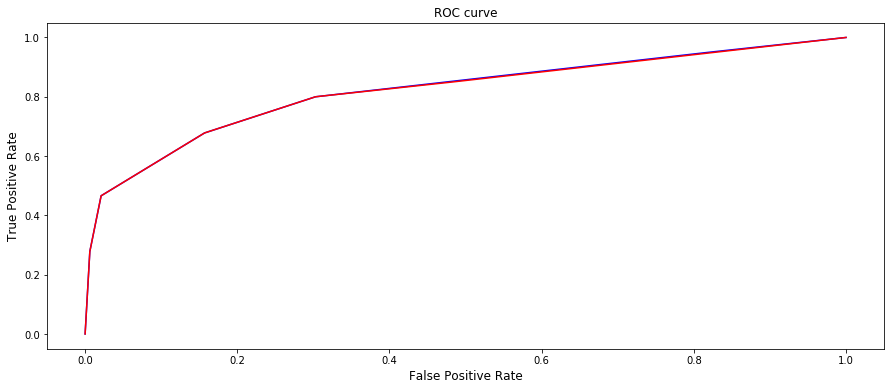


AUC Naive Bayes Classifier:
0.8187651421508035

AUC Bayes Classifier:
0.8200012360939432

We can see that for the whole dataset ROC and AUC
are pretty much the same for Bayes Classifier and Naive Bayes Classifier.
ROC and AUC is a bit better for the Bayes Classifier though.


In [19]:
print("\n\n------------COMPARISON--BAYES--CLASSIFIER--vs--NAIVE--BAYES--CLASSIFIER-------------------------------\n")

print("\nROC curves for Bayes Classifier (blue) and Naive Bayes Classifier (red)\n")
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)
ax.set_title("ROC curve")
ax.set_xlabel("False Positive Rate",fontsize=12)
ax.set_ylabel("True Positive Rate",fontsize=12)

ax.plot(fpr, tpr,color="blue")
ax.plot(fprn, tprn, color='red')

plt.show()

print("\nAUC Naive Bayes Classifier:")
print(roc_auc_score(y_wholen, score_wholen))
print("\nAUC Bayes Classifier:")
print(roc_auc_score(y_whole, score_whole))


print("\nWe can see that for the whole dataset ROC and AUC")
print("are pretty much the same for Bayes Classifier and Naive Bayes Classifier.")
print("ROC and AUC is a bit better for the Bayes Classifier though.")

## Problem 2

Add age as a feature and implement naive bayes classifier. 

#### Hint: 
Consider using it as a categorical variable

In [21]:
data_with_age = data.copy()
data_pclass_sex_age = data_with_age[['survived','sex','pclass','age']]
data_pclass_sex_age = data_pclass_sex_age.dropna(how='any')


print("I chose the following features: pclass, sex, survived, age.")
print("The first five records of data_pclass_sex_age_train and data_pclass_sex_age_test:\n")
print(data_pclass_sex_age.head())
age_category = pd.cut(data_pclass_sex_age['age'], bins=[0,18,65,99], labels=['child','adult','senior'])

data_pclass_sex_age = data_pclass_sex_age.drop(columns=['age'])
data_pclass_sex_age.insert(3,'age_category',age_category)

print("\n\nData after adding age_category (child(0-18), adult(18-65), senior(64,99)).")
print("The first five records of data_pclass_sex_age_train and data_pclass_sex_age_test:\n")
print(data_pclass_sex_age.head())

I chose the following features: pclass, sex, survived, age.
The first five records of data_pclass_sex_age_train and data_pclass_sex_age_test:

   survived     sex  pclass      age
0         1  female       1  29.0000
1         1    male       1   0.9167
2         0  female       1   2.0000
3         0    male       1  30.0000
4         0  female       1  25.0000


Data after adding age_category (child(0-18), adult(18-65), senior(64,99)).
The first five records of data_pclass_sex_age_train and data_pclass_sex_age_test:

   survived     sex  pclass age_category
0         1  female       1        adult
1         1    male       1        child
2         0  female       1        child
3         0    male       1        adult
4         0  female       1        adult


In [27]:
grouped_with_age = data_pclass_sex_age.groupby(['survived','sex','pclass','age_category'])
counts_with_age = grouped_with_age.size()

print("\nCounts of dead and survivors in our data sample:")
print(counts_with_age)


Counts of dead and survivors in our data sample:
survived  sex     pclass  age_category
0         female  1       child             1
                          adult             4
                          senior            0
                  2       child             1
                          adult            10
                          senior            0
                  3       child            27
                          adult            53
                          senior            0
          male    1       child             2
                          adult            92
                          senior            4
                  2       child            10
                          adult           123
                          senior            2
                  3       child            57
                          adult           231
                          senior            2
1         female  1       child            12
                          adult      

In [51]:
#2 b). There is more possible combinations of passenger's features so 
#I will use pandas instead of numpy like in the 1 problem.
#I will define a function and apply it to all records of the given dataset.

def naivebayes(row):    

    P_surv=counts_with_age[1].sum()/counts_with_age.sum()
    
    if row['sex'] == 'female':
        Psx=counts_with_age.loc[1,'female',:,:].sum()/counts_with_age[1].sum()
    else:
        Psx=counts_with_age.loc[1,'male',:,:].sum()/counts_with_age[1].sum()
    if row['pclass'] == 1:
         Pclass= counts_with_age.loc[1,:,1,:].sum()/counts_with_age[1].sum()
    elif row['pclass'] == 2:
         Pclass= counts_with_age.loc[1,:,2,:].sum()/counts_with_age[1].sum()
    else:
        Pclass= counts_with_age.loc[1,:,3,:].sum()/counts_with_age[1].sum()
    if row['age_category'] == 'child':
        Pa=counts_with_age.loc[1,:,:,'child'].sum()/counts_with_age[1].sum()
    elif row['age_category'] == 'adult':
        Pa=counts_with_age.loc[1,:,:,'adult'].sum()/counts_with_age[1].sum()
    else:
        Pa=counts_with_age.loc[1,:,:,'senior'].sum()/counts_with_age[1].sum()
    
#    Psx_age_class=counts_with_age.loc[:,row['sex'],row['pclass'],row['age_category']].sum()/counts_with_age.sum()
    counts_with_age.loc[1,'female',:,:]
    
    
    Psx_age_class=
    
    val = (Pa*Psx*Pclass*P_surv)/Psx_age_class

    return val

In [52]:
data_pclass_sex_age['nb_probability']=data_pclass_sex_age.apply(naivebayes, axis=1)
data_pclass_sex_age.head()

,survived,sex,pclass,age_category,nb_probability,survived prediction,TP,FP,TN,FN
0,1,female,1,adult,0.001077,0,0,0,0,1
1,1,male,1,child,0.000369,0,0,0,0,1
2,0,female,1,child,0.001354,0,0,0,1,0
3,0,male,1,adult,0.000294,0,0,0,1,0
4,0,female,1,adult,0.001077,0,0,0,1,0


In [48]:
def categorizer(row):
    if row['nb_probability']>0.5:
        valc=1
    else:
        valc=0
    return valc

data_pclass_sex_age['survived prediction']=data_pclass_sex_age.apply(categorizer, axis=1)        
data_pclass_sex_age.head()

,survived,sex,pclass,age_category,nb_probability,survived prediction,TP,FP,TN,FN
0,1,female,1,adult,5.243395e-09,0,0,0,0,1
1,1,male,1,child,5.243395e-09,0,0,0,0,1
2,0,female,1,child,5.243395e-09,0,0,0,1,0
3,0,male,1,adult,5.243395e-09,0,0,0,1,0
4,0,female,1,adult,5.243395e-09,0,0,0,1,0


In [38]:
def TP(row):
    if (row['survived']==row['survived prediction']) and (row['survived prediction']==1):
        valtp=1
    else:
        valtp=0
    return valtp

def FP(row):
    if (row['survived']!=row['survived prediction']) and (row['survived prediction']==1):
        valfp=1
    else:
        valfp=0
    return valfp

def TN(row):
    if (row['survived']==row['survived prediction']) and (row['survived prediction']==0):
        valtn=1
    else:
        valtn=0
    return valtn

def FN(row):
    if (row['survived']!=row['survived prediction']) and (row['survived prediction']==0):
        valfn=1
    else:
        valfn=0
    return valfn

In [39]:
data_pclass_sex_age['TP']=data_pclass_sex_age.apply(TP, axis=1)    
data_pclass_sex_age['FP']=data_pclass_sex_age.apply(FP, axis=1)
data_pclass_sex_age['TN']=data_pclass_sex_age.apply(TN, axis=1)    
data_pclass_sex_age['FN']=data_pclass_sex_age.apply(FN, axis=1)
data_pclass_sex_age.head()

,survived,sex,pclass,age_category,nb_probability,survived prediction,TP,FP,TN,FN
0,1,female,1,adult,0.408222,0,0,0,0,1
1,1,male,1,child,0.408222,0,0,0,0,1
2,0,female,1,child,0.408222,0,0,0,1,0
3,0,male,1,adult,0.408222,0,0,0,1,0
4,0,female,1,adult,0.408222,0,0,0,1,0



When prob>0.5 => return 1 else return 0


TP(for prob=0.5 treshold):  0
FP(for prob=0.5 treshold):  0
TN(for prob=0.5 treshold):  619
FN(for prob=0.5 treshold):  427


TPR(for prob=0.5 treshold):  0.0
FPR(for prob=0.5 treshold):  0.0
TNR(for prob=0.5 treshold):  1.0
FNR(for prob=0.5 treshold):  1.0
TNR+FPR(for prob=0.5 treshold):  1
TPR+FNR(for prob=0.5 treshold):  1

Let's make the above more general. Let's calculate TPR and FPR for several different tresholds
and plot them against each other.

--------------ROC---------------RECEIVER---OPERATOR---CHARACTERSTIC-----------------------------------

When prob>treshold => return 1 else return 0


prob tresholds:
 [1.4082218 0.4082218 0.4082218 0.4082218 0.4082218 0.4082218]


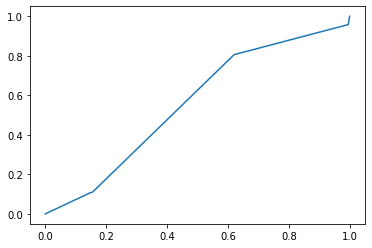

--------------AUC-------------------------------AREA---UNDER---CURVE-----------------------------------

0.5569457423584916


In [40]:
tp=data_pclass_sex_age['TP'].sum()
fp=data_pclass_sex_age['FP'].sum()
tn=data_pclass_sex_age['TN'].sum()
fn=data_pclass_sex_age['FN'].sum()
p=tp+fn
n=tn+fp


print("\nWhen prob>0.5 => return 1 else return 0\n")            
print("\nTP(for prob=0.5 treshold): ", int(tp))
print("FP(for prob=0.5 treshold): ", int(fp))
print("TN(for prob=0.5 treshold): ", int(tn))
print("FN(for prob=0.5 treshold): ", int(fn))
print("\n")
print("TPR(for prob=0.5 treshold): ", float(tp/p))
print("FPR(for prob=0.5 treshold): ", float(fp/n))
print("TNR(for prob=0.5 treshold): ", float(tn/n))
print("FNR(for prob=0.5 treshold): ", float(fn/p))

print("TNR+FPR(for prob=0.5 treshold): ", int((tn+fp)/n))
print("TPR+FNR(for prob=0.5 treshold): ", int((tp+fn)/p))

labels2 = data_pclass_sex_age[['survived']]
score2 = data_pclass_sex_age[['nb_probability']]

print("\nLet's make the above more general. Let's calculate TPR and FPR for several different tresholds")
print("and plot them against each other.\n")
print("--------------ROC---------------RECEIVER---OPERATOR---CHARACTERSTIC-----------------------------------\n")
      
fpr2, tpr2, thresholds2 = roc_curve(labels2, score2)

print("When prob>treshold => return 1 else return 0\n")
print("\nprob tresholds:\n",thresholds2)

plt.plot(fpr2,tpr2)
plt.show()
print("--------------AUC-------------------------------AREA---UNDER---CURVE-----------------------------------\n")
print(roc_auc_score(labels2, score2))



------------COMPARISON--BAYES--CLASSIFIER--vs--NAIVE--BAYES--CLASSIFIER---WITH_AGE/WITHOUT_AGE--------------


ROC curves for Bayes Classifier (without age) (blue) and Naive Bayes Classifier with age (green)/without age (red)



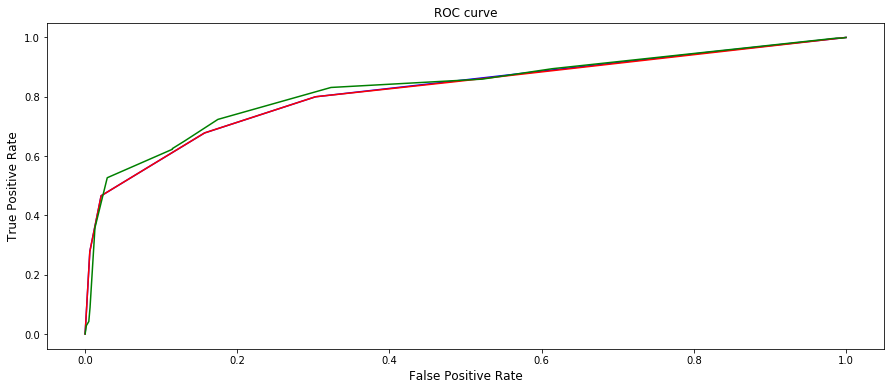


AUC Bayes Classifier (without age) blue:
0.8200012360939432

AUC Naive Bayes Classifier (without age) red:
0.8187651421508035

AUC Naive Bayes Classifier (with age) green:
0.8286557982392088

AUC and ROC of Naive Bayes Classifier with age (green) seems to be the best.


In [34]:
print("\n\n------------COMPARISON--BAYES--CLASSIFIER--vs--NAIVE--BAYES--CLASSIFIER---WITH_AGE/WITHOUT_AGE--------------\n")

print("\nROC curves for Bayes Classifier (without age) (blue) and Naive Bayes Classifier with age (green)/without age (red)\n")
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)
ax.set_title("ROC curve")
ax.set_xlabel("False Positive Rate",fontsize=12)
ax.set_ylabel("True Positive Rate",fontsize=12)

ax.plot(fpr, tpr,color="blue")
ax.plot(fprn, tprn, color='red')
ax.plot(fpr2,tpr2, color='green')

plt.show()

print("\nAUC Bayes Classifier (without age) blue:")
print(roc_auc_score(y_whole, score_whole))

print("\nAUC Naive Bayes Classifier (without age) red:")
print(roc_auc_score(y_wholen, score_wholen))

print("\nAUC Naive Bayes Classifier (with age) green:")
print(roc_auc_score(labels2, score2))

print("\nAUC and ROC of Naive Bayes Classifier with age (green) seems to be the best.")